
### Energy-based models assignment; implementation problem

This is a (hopefully shorter, compared to hw2) implementation problem of the third assignment. We will investigate convolutional auto-encoders and denoising convolutional auto-encoders.

### Prereqs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




**Question 1 (of this notebook):**

Estimated time: 10 min.

We first load the data.

TODO:
- Print out a few shapes. See comments in the below cell. Can be done in three lines of code, but you're welcome to provide a more complicated solution.

In [ ]:
import datetime
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import sys

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils import data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms


def load_fashion_mnist(batch_size=64):
    # One convention (of the many) is to use a real number between -1 and 1
    # (inclusive) to represent each pixel; instead of an integer from 0 to 255.
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

    train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=transform)

    # Create validation set from training set, given that torchvision only gives
    # us the train/test split.  
    num_train = len(train_dataset)
    indices = list(range(num_train))
    valid_size = 0.1
    split = int(np.floor(valid_size * num_train))

    random_seed = 123
    np.random.seed(random_seed)  # think: why do we do this?
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = data.SubsetRandomSampler(train_idx)
    valid_sampler = data.SubsetRandomSampler(valid_idx)
    train_loader = data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=valid_sampler)
    test_dataset = datasets.FashionMNIST(root='./data', train=False,
                                         download=True, transform=transform)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size,
                                  shuffle=False)
    
    # TODO: the images in training, validation, and test sets have shape:
    # [num of examples, image height, image weight];
    # write a few lines of code to print out the three (train/val/test) shapes;
    # for example, the test set image shape should be [10000, 28, 28];
    # try exploring the dataset using test_dataset[7], test_dataset.data, etc.
    print(train_dataset.data[train_idx].shape)
    print(train_dataset.data[valid_idx].shape)
    print(test_dataset.data.shape)
    
    #raise NotImplementedError

    return train_loader, valid_loader, test_loader

def imshow(img):
    # First unnormalize if we want to print out the image. We're using the
    # convention that each image pixel is between -1 and 1. But when python
    # prints out images, the pixel needs to be between 0 and 1.
    img = img / 2 + 0.5
    img_numpy = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))

In [ ]:
batch_size = 64
train_loader, valid_loader, test_loader = load_fashion_mnist(batch_size)

torch.Size([54000, 28, 28])
torch.Size([6000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
!nvidia-smi  # make sure you're using GPUs when you are about to train the model

Fri Oct 30 20:19:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

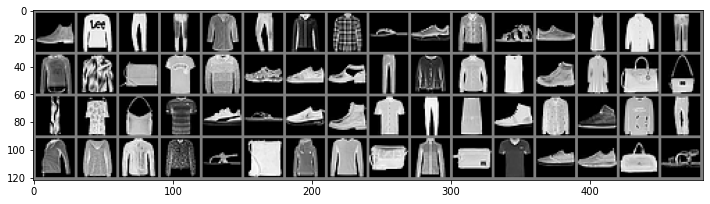

In [ ]:
# Taking a look at what the images are like
images = next(iter(test_loader))[0][:64]
imshow(torchvision.utils.make_grid(images, nrow=16))

Check out the ten classes on page 3: https://arxiv.org/pdf/1708.07747.pdf
- 0: t-shirt/top; 1: trouser; 2: pullover; 3: dress; 4: coat; 5: sandals; 6: shirt; 7: sneaker; 8: bag; 9: ankle boots.

<!-- For CIFAR10, check out the ten classes here: https://www.cs.toronto.edu/~kriz/cifar.html
- Airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck -->

This dataset is much more difficult on the classification task, compared to the digit MNIST which we saw in Lab 2. However, **today we will NOT be doing classification!!! So let's assume that the labels DO NOT EXIST in the iterators (the data loaders)!**

### Model

Next, we will implement two versions of autoencoders: (1) convolutional autoencoder; (2) denoising convolutional autoencoder (but actually we'll be using the same model code, explained later).

**Question 2: implement a convolutional autoencoder**

Estimated time: 30 min.

TODO
- In CAE class below, complete the init function and the forward function, such that your implementation satisfies the following requirements.
  - The output image dimension (from the forward function) is exactly the same as the input image dimension. 
  - There are two Conv2d layer in the encoder, followed by three Conv2d or ConvTranspose2d blocks in the decoder. The out_channel for the second convolutional layer in the encoder should be >= 16 (for example, 16 or 32; feel free to experiment other choices).
    - Use ReLU or some other similar nonlinearities, followed by pooling, after each convolution layer in the encoder. 
    - Use ReLU or some other similar nonlinearities, after each convolution layer in the decoder (except for the very last convolution layer). Suggestion (but no need to follow this advice): the out_channel size for the decoder convolutional layers should be smaller and smaller (meaning the out_channel for first decoding conv2d layer should be bigger than out_channel for second decoding conv2d layer).
    - Add batch normalization layers after the nonlinearities, just like what you may have done in the previous homework. 
    - In decoder, if you want to obtain an output feature map with size larger than size of input feature map, consider using ConvTranspose2d, or UpsamplingBilinear2d, after figuring out what they do.
    - No hard requirement on what padding or stride to use, but make sure they're small, given that our image is only 28*28. 
  - Note that your parameters (e.g., number of filters in the intermediate layers) should not be too big, given that our image is greyscale and has 28*28 pixels only.



In [ ]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

In [ ]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, stride= 1, padding=0)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size= 2)

        self.conv2 = nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, stride= 1, padding= 0)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size= 2)

        # Decoder
        self.tran1 = nn.ConvTranspose2d(in_channels= 16, out_channels= 8, stride= 2, padding= 1, kernel_size= 3, output_padding= 1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(8)

        self.tran2 = nn.ConvTranspose2d(in_channels= 8, out_channels= 4, stride= 2, padding= 1, kernel_size= 3, output_padding= 1)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(4)

        self.tran3= nn.ConvTranspose2d(in_channels= 4, out_channels= 1, kernel_size= 3, stride= 2, padding= 7, output_padding= 1)

        #raise NotImplementedError

    def forward(self, y):
        """Forward function of CAE class.

        Args:
          y: a batch of input images.
        
        Returns:
          yhat: the batch of reconstructed images.
        """
        # Encoder
        x = self.conv1(y)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        # Decoder
        x = self.tran1(x)
        x = self.act3(x)
        x = self.bn3(x)
        
        x = self.tran2(x)
        x = self.act4(x)
        x = self.bn4(x)

        yhat = self.tran3(x)
        
        return yhat
        #raise NotImplementedError


**Question 3: complete the train() and validate() function to be used later**

Estimated time: 10 min.

TODO
- Complete the train() function.
  - Hint: recall the five steps we discussed in Lab 2.
  - Make sure your images are on GPUs (device cuda) before you train. Otherwise, your training may be extremely extremely slow and it may take you 50 times longer than other people.

- Complete the validate() function:
  - The only thing we need to do is to save the model when we achieve the best validation loss so far. So, check out the pytorch documentation or the third lab, for how to save checkpoints. Make sure to do this step because we need to load the model later.

In [ ]:
# This is part of question 4.
def add_noise(images):
    mean = 0
    sigma = np.random.uniform(0, 1)
    gaussian = np.random.normal(mean, sigma, (images.shape[2],images.shape[3]))
    images_noisy = images + gaussian
    images_noisy = images_noisy.float()
    torch.clamp(images_noisy, min= -1, max= 1)
    #raise NotImplementedError
    return images_noisy

In [ ]:
torch.rand(images.shape[0]).view(-1, 1, 1, 1).shape

torch.Size([64, 1, 1, 1])

In [ ]:
def train(autoencoder, train_loader, epoch, num_epoch, learning_rate,
          weight_decay, log_interval, denoising=False):
    # Using sum reduction simply bc otherwise, the scale of the loss is too small;
    # given that we always have 28*28 images, using sum/mean reduction wouldn't
    # make a difference.
    criteria = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(
        autoencoder.parameters(), lr=learning_rate, weight_decay= weight_decay)
    autoencoder.train()
    for i, data in enumerate(train_loader):
        images, _ = data

        if denoising:
            input_images = add_noise(images)
        else:
            input_images = images
        
        if cuda:
            input_images = input_images.to(device)
            images = images.to(device)
        
        prediction = autoencoder(input_images)
        loss = criteria(prediction, images)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        #raise NotImplementedError
        if (i + 1) % log_interval == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], MSE loss:{:.6f}'.format(
                epoch + 1, num_epoch, i + 1,
                len(train_loader.dataset) // batch_size, loss.item() / batch_size
            ))


def validate(autoencoder, valid_loader, best_val_loss, denoising=False):
    total_loss = 0
    criteria = nn.MSELoss(reduction='sum')
    autoencoder.eval()
    for i, data in enumerate(valid_loader):
        images, _ = data
        if denoising:
            input_images = add_noise(images)
        else:
            input_images = images
        if cuda:
            input_images = input_images.to(device)
            images = images.to(device)
        outputs = autoencoder(input_images)
        loss = criteria(outputs, images)
        total_loss += loss
    avg_loss = total_loss / (len(valid_loader) * batch_size)

    print('\nLoss per batch on validation set: {:.6f}'.format(avg_loss))

    if avg_loss < best_val_loss:
        if denoising:
            save_path = '/content/drive/My Drive/Colab Notebooks/best_model_denoising.pt'
        else:
            save_path = '/content/drive/My Drive/Colab Notebooks/best_model.pt'
        best_val_loss = avg_loss
        #raise NotImplementedError
        torch.save(autoencoder.state_dict(), save_path)
        print('Saved best model in the checkpoint directory\n')
    
    return best_val_loss

def evaluate(autoencoder, test_loader, denoising=False):
    total_loss = 0
    criteria = nn.MSELoss(reduction='sum')
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images, _ = data
        if denoising:
            input_images = add_noise(images)
        else:
            input_images = images
        if cuda:
            input_images = input_images.to(device)
            images = images.to(device)
        outputs = autoencoder(input_images)
        loss = criteria(outputs, images)
        total_loss += loss
    avg_loss = total_loss / (len(test_loader) * batch_size)

    print('\nMSE loss per batch on test set: {:.6f}'.format(avg_loss))


**Question 4: implement a denoising convolutional autoencoder**

Estimated time: 20 min.

The input to a denoising CAE is a perturbed image, and the output is the original image. Given that we're using the same network, there's nothing we need to change about the CAE class. 

TODO
- However, add an argument called ```denoising``` (defaulted to be ```False```) in the train() to indicate if our input will be the noisy version (in this case ```denoising=True```) or a clean version (in this case ```denoising=False```), and modify the functions appropriately, with the following instructions. Do the same for validate() and evaluate() to decide if we want to validate/evaluate on noisy or clean images.

- Perturbation (i.e., making images noisy)
  - First make sure that each pixels are represented by a real number from -1 to 1 (instead of integers from 0 to 255). The pixel should be already from -1 to 1, unless you did something you shouldn't have done. 
  - Next, do a perturbation to each image where the noise is sampled according to the standard Gaussian distribution and then multiplied by a number uniformly sampled from 0 to 1.
    - In other words, each pixel in image i should be perturbed with a noise (1) sampled from a standard Gaussian distribution and then (2) multiplied by $c_i$ for some $c_i \in (0,1)$, and each pixel in image j should be perturbed with a noise (1) sampled from a standard Gaussian distribution and then (2) multiplied by $c_j$ for some $c_j \in (0,1)$. (In fact, the result is that for each image, we're still sampling the noise from a Gaussian distribution; the mean is 0, and the standard deviation is sampled from a uniform distribution. Think: why?)
    - Make sure that the resulting perturbed/noisy image are still represented by numbers from -1 to 1 (so you may need to do some clipping with min -1 and max 1). 

- To add noise to a batch of images, please use a helper function called add_noise(), outside the train(), validate(), evaluate() functions.

In [ ]:
## Training CAE with original images as input
batch_size = 64
best_val_loss = float('inf')
num_epoch = 100
learning_rate = 1e-3
log_interval = 100
weight_decay = 1e-3
denoising = False
keep_training_from_ckpt = False

if denoising:
    load_path = '/content/drive/My Drive/Colab Notebooks/best_model_denoising.pt'
else:
    load_path = '/content/drive/My Drive/Colab Notebooks/best_model.pt'

conv_autoencoder = CAE()
#print(conv_autoencoder)

if cuda:
    conv_autoencoder.to(device)

for epoch in range(num_epoch):
    start_time = datetime.datetime.now()
    train(conv_autoencoder, train_loader, epoch, num_epoch, learning_rate,
          weight_decay, log_interval, denoising)
    end_time = datetime.datetime.now()
    print(f'Trained this epoch using {(end_time - start_time).seconds} seconds')
    # validate and save model if it's the best model so far
    best_val_loss = validate(conv_autoencoder, valid_loader, best_val_loss,
                             denoising)
print('Training done; best validation loss {:.4f}'.format(best_val_loss))

Epoch [1/100] - Iter[100/937], MSE loss:348.652161
Epoch [1/100] - Iter[200/937], MSE loss:211.649826
Epoch [1/100] - Iter[300/937], MSE loss:176.897644
Epoch [1/100] - Iter[400/937], MSE loss:161.014038
Epoch [1/100] - Iter[500/937], MSE loss:175.303589
Epoch [1/100] - Iter[600/937], MSE loss:154.709167
Epoch [1/100] - Iter[700/937], MSE loss:155.515793
Epoch [1/100] - Iter[800/937], MSE loss:155.660522
Trained this epoch using 18 seconds

Loss per batch on validation set: 140.934570
Saved best model in the checkpoint directory

Epoch [2/100] - Iter[100/937], MSE loss:144.149078
Epoch [2/100] - Iter[200/937], MSE loss:122.880997
Epoch [2/100] - Iter[300/937], MSE loss:132.235077
Epoch [2/100] - Iter[400/937], MSE loss:143.180191
Epoch [2/100] - Iter[500/937], MSE loss:127.487175
Epoch [2/100] - Iter[600/937], MSE loss:124.934891
Epoch [2/100] - Iter[700/937], MSE loss:146.272949
Epoch [2/100] - Iter[800/937], MSE loss:120.686584
Trained this epoch using 17 seconds

Loss per batch on v

**Question 5: Training**

Estimated debugging time: 30 min, or longer if you have more severe bugs.

TODO

- Now, train your CAE model (where your input is the original images), and train your denoising CAE model (where your input is the noisy images). You can set a patience counter on your own (similar to homework 2), meaning if validation loss doesn't decrease for, say, 10 epochs (just an example), then you can stop training. Each training procedure may take half an hour or an hour. It may take many many more hours if you didn't move the model or the data onto GPUs. Moreover, to make sure your training is not lost in case colab disconnects, it's important to save checkpoints! Make sure you wrote the checkpoint saving code in the validate function.
- Report the best validation loss. No need to plot the curve, but you can plot it nevertheless to have a better understanding on your training process.

Estimated training time in total: 2 hours (depending on your model)?
- Please do not spend the 2 hours staring at your log.
- You don't need to get the "best" model. You only need Question 6, Question 7, and Question 8 to work. Q6 works if your reconstructed images aren't bad (okay to be blurry); Q7 works if your plots looks similar to the presented; Q8 works if ...please read Q8.

In [ ]:
## Training CAE with denoising images as input
batch_size = 64
best_val_loss = float('inf')
num_epoch = 100
learning_rate = 1e-3
log_interval = 100
weight_decay = 1e-3
denoising = True
keep_training_from_ckpt = False

if denoising:
    load_path = '/content/drive/My Drive/Colab Notebooks/best_model_denoising.pt'
else:
    load_path = '/content/drive/My Drive/Colab Notebooks/best_model.pt'

conv_autoencoder_denoising = CAE()
#print(conv_autoencoder)

if cuda:
    conv_autoencoder_denoising.to(device)

for epoch in range(num_epoch):
    start_time = datetime.datetime.now()
    train(conv_autoencoder_denoising, train_loader, epoch, num_epoch, learning_rate,
          weight_decay, log_interval, denoising)
    end_time = datetime.datetime.now()
    print(f'Trained this epoch using {(end_time - start_time).seconds} seconds')
    # validate and save model if it's the best model so far
    best_val_loss = validate(conv_autoencoder_denoising, valid_loader, best_val_loss,
                             denoising)
print('Training done; best validation loss {:.4f}'.format(best_val_loss))

Epoch [1/100] - Iter[100/937], MSE loss:278.148499
Epoch [1/100] - Iter[200/937], MSE loss:207.351868
Epoch [1/100] - Iter[300/937], MSE loss:206.465698
Epoch [1/100] - Iter[400/937], MSE loss:178.869934
Epoch [1/100] - Iter[500/937], MSE loss:166.401276
Epoch [1/100] - Iter[600/937], MSE loss:182.444244
Epoch [1/100] - Iter[700/937], MSE loss:162.903290
Epoch [1/100] - Iter[800/937], MSE loss:150.735535
Trained this epoch using 18 seconds

Loss per batch on validation set: 166.257355
Saved best model in the checkpoint directory

Epoch [2/100] - Iter[100/937], MSE loss:171.139526
Epoch [2/100] - Iter[200/937], MSE loss:138.900940
Epoch [2/100] - Iter[300/937], MSE loss:154.471146
Epoch [2/100] - Iter[400/937], MSE loss:142.135971
Epoch [2/100] - Iter[500/937], MSE loss:184.026825
Epoch [2/100] - Iter[600/937], MSE loss:146.545319
Epoch [2/100] - Iter[700/937], MSE loss:187.054199
Epoch [2/100] - Iter[800/937], MSE loss:130.164093
Trained this epoch using 18 seconds

Loss per batch on v

**Question 6: evaluate on test sets**

Estimated time: 10 min.

Only run the below cell when you're done with training, and you're evaluating on test sets.

TODO:
- Print out the reconstruction loss on test set for both the CAE and denoising CAE models.
- Print out a few reconstructed images (for both models). Here, the input to CAE should be clean images; the input to denoising CAE should be noisy images. It's perfectly fine if your reconstructed images are blurry. If your reconstructed image is extremely bad (for example, if you absolutely can't tell what object it is anymore), then you probably made a mistake in the previous steps. You might have chosen an overly small out_channel, for example. Or, learning might be inadequate. Or, you made a mistake in model saving / model loading.

In [ ]:
# Only run at evaluation time!

def print_loss_and_reconstructed_images(denoising):
    conv_autoencoder_test = CAE()
    if denoising:
        conv_autoencoder_test.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/best_model_denoising.pt'))
    else:
        conv_autoencoder_test.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/best_model.pt'))
    if cuda:
        conv_autoencoder_test.cuda()
    # TODO: evaluate on test set and print out reconstruction loss
    #raise NotImplementedError

    #conv_autoencoder_test.cpu()
    # TODO: print out a few (perhaps 16 or 32) reconstructed images for both models
    # no need to follow the below code
    conv_autoencoder_test.cpu()
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images[:32]
    if denoising:
        images_noisy = add_noise(images)
    else:
        images_noisy = images
    outputs = conv_autoencoder_test(images_noisy)

    plt.figure()
    imshow(torchvision.utils.make_grid(images_noisy.data))
    plt.figure()
    imshow(torchvision.utils.make_grid(outputs.data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

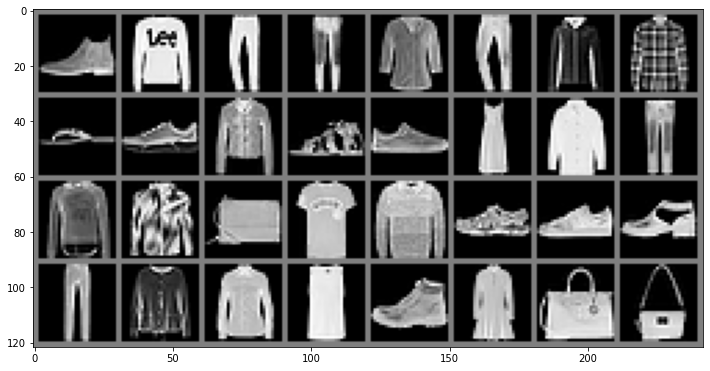

<Figure size 432x288 with 0 Axes>

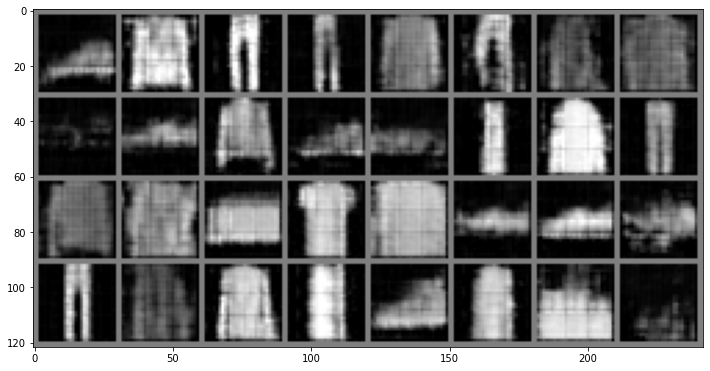

<Figure size 432x288 with 0 Axes>

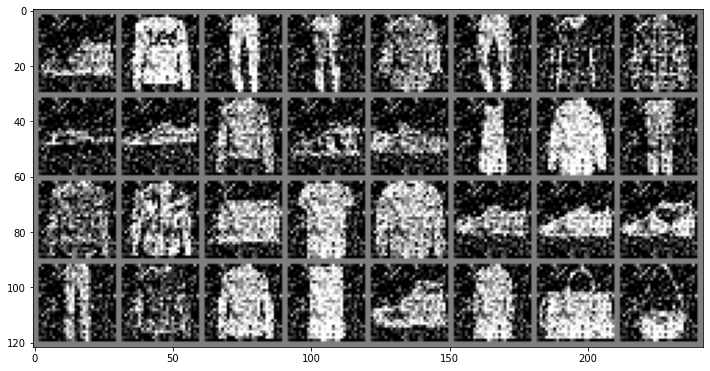

<Figure size 432x288 with 0 Axes>

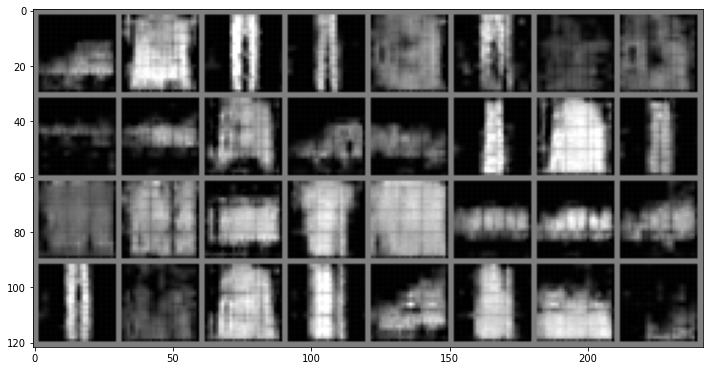

In [ ]:
print_loss_and_reconstructed_images(False)
print_loss_and_reconstructed_images(True)

### Plotting loss vs. noise length

**Question 7: plot loss vs. noise length**

Estimated time: 30 min.

TODO:
For both CAE and denoising CAE models you trained, plot loss vs. noise length, for five different images in five separate plots.
- Terminology
  - The noise length is the L2 norm of the noise you added to the image. So, it will be the norm of image_noisy minus image. 
  - The loss refers to the reconstruction loss.

- For each image...
  - **In this part, the input to both CAE and denoising CAE should be noisy images.** But how much noise?
  - For each image, at least add 100 different noises with different length (so we're doing at least 100 "trials"). Perhaps you can use different standard deviations in the Gaussian distribution (when you add the noise into the images). For example, you can refer to the provided add_noise_coeff function with coeff as an input argument. You don't need to use this function. 
  - Compute the reconstruction loss for each noise you added. 
  - Now you would have the following list [(noise length #1, loss #1), (noise length #2, loss #2), ..., (noise length #n, loss #n)] (where n is at least 100) for CAE. You should have a similar list for denoising CAE. Now plot the loss (vertical axis) and length (horizontal axis), of two models, in the same plot. But note that the plot only corresponds to one original clean image.

- Do the above for 3 different images.

- Feel free to use get_length_and_loss as a template. However, absolutely no need to follow the logic of get_length_and_loss.

- For each image, you should see a plot similar to the below trend. Think: why? No need to explain.


In [ ]:
def add_noise_coeff(images, coeff):
    noise = torch.mul(
        torch.randn(images.shape),
        torch.tensor([coeff]).view(-1, 1, 1, 1))
    images = images.cpu()
    images_noisy = images + noise
    images_noisy = torch.clamp(images_noisy, -1.0, 1.0)
    return images_noisy

In [ ]:
# Plot loss vs. length

denoising = False

loss_cae = []
length_cae = []
loss_dcae = []
length_dcae = []

def get_length_and_loss(denoising):
    loss_ae = []
    length_ae = []
    autoencoder = CAE()

    if denoising:
        autoencoder.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/best_model_denoising.pt'))
    else:
        autoencoder.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/best_model.pt'))
    if cuda:
        autoencoder.cuda()

    total_loss = 0
    # Updated from reduction = none to sum
    criteria = nn.MSELoss(reduction='sum')
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images, _ = data
        coefficient = 0.0
        while coefficient < 1.5:
            #if denoising:
            input_images = add_noise_coeff(images, coefficient)
            #else:
            #  input_images = images
            if cuda:
              input_images = input_images.to(device)
              images = images.to(device)
            
            output = autoencoder(input_images)
            loss = criteria(output, images)
            length = torch.norm(input_images - images)
            
            loss_ae.append(loss)
            length_ae.append(length)
            #raise NotImplementedError
            coefficient += 0.01
        return loss_ae, length_ae

In [ ]:
loss_cae, length_cae = get_length_and_loss(False)
loss_dcae, length_dcae = get_length_and_loss(True)

In [ ]:
loss_cae = [float(x) for x in loss_cae]
length_cae = [float(x) for x in length_cae]

In [ ]:
loss_dcae = [float(x) for x in loss_dcae]
length_dcae = [float(x) for x in length_dcae]

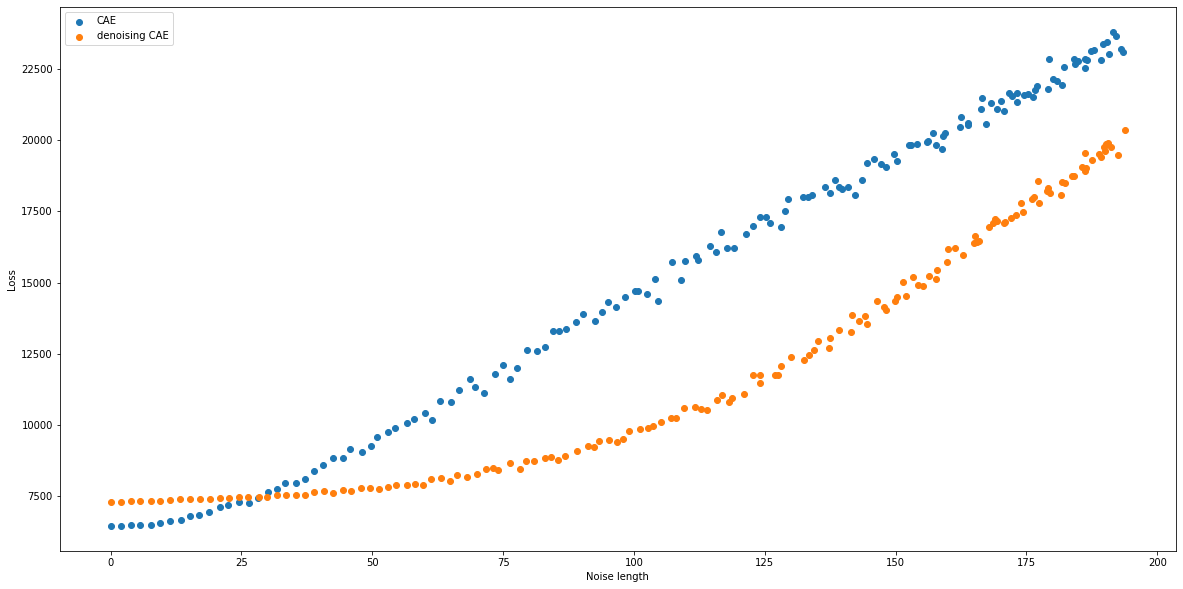

In [ ]:
# Feel free to make the plot prettier.
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.scatter(length_cae, loss_cae, label='CAE')
plt.scatter(length_dcae, loss_dcae, label='denoising CAE')
plt.xlabel('Noise length')
plt.ylabel('Loss')
plt.legend()

### Visualizing interpolation

Congrats on getting this far! Here is a final question.

**Question 8: interpolating latents**

Estimated time: 30 min to 1 hour.

Suppose the encoder is E, decoder is D. We essentially did the following: yhat = D(E(y)) where y is the input and yhat is the reconstructed image.

Let z = E(y), so z is called the latent. Specifically, we obtain z after the batch normalization / pooling layers of the encoder.

Now, let's try interpolating the z for one image and the z for another image!

TODO:
- Suppose the 0th image in the test set is called y0, and the 1st image in the test set is called y1. They correspond to latents z0 and z1 respectively.
- Now, set new z by one of the following eleven choices and then print out the reconstructed image. 
  - z = 0.0 * z0 + 1.0 * z1
  - z = 0.1 * z0 + 0.9 * z1
  - z = 0.2 * z0 + 0.8 * z1
  - ...
  - z = 1.0 * z0 + 0.0 * z1
- So, your result (to be submitted) should be...
  - an image generated by the following latent: z = 0.0 * z0 + 1.0 * z1
  - an image generated by the following latent: z = 0.1 * z0 + 0.9 * z1
  - ...
  - an image generated by the following latent: z = 1.0 * z0 + 0.0 * z1
- Hint: you should see that your images gradually change from y1 to y0. If y1 is a tshirt and y0 is a shoe, then you should see that the images change gradually from a tshirt to a shoe.
- You only need to do this for the regular CAE.
- Explain clearly what your y1 is, and what your y0 is.





Here is some code which may be helpful. You don't need to use the below.
```
    model_children = list(model.children())
    print("model children: ", model_children)
```
You can use elements in model_children to process your inputs. You can also add another helper function (other than init and forward) in the CAE class. Your call!


In [ ]:
autoencoder = CAE()
autoencoder.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/best_model.pt'))
autoencoder.cpu()

CAE(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tran1): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (act3): ReLU()
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tran2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (act4): ReLU()
  (bn4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tran3): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), 

In [ ]:
def get_latent(model, image):
  intermediate_layers = list(model.children())
  iter = 7
  output = intermediate_layers[0](image[None, ...])
  for i in range(iter):
    output = intermediate_layers[i+1](output) 
  return output

def get_output(model, latent):
  intermediate_layers = list(model.children())
  iter = 8
  l = len(intermediate_layers)
  temp_latent = latent
  for i in range(iter, l):
    output = intermediate_layers[i](temp_latent)
    temp_latent = output
  return output

def visualize_one_model(model, image_id, image_id2, gamma1):
  image_1 = next(iter(test_loader))[0][image_id]
  z1 = get_latent(model, image_1)
  
  image_2 = next(iter(test_loader))[0][image_id2]
  z2 = get_latent(model, image_2)
  
  z = gamma1 * z1 + (1 - gamma1) * z2
  output = get_output(model, z)
  output = output.detach()
  return output
  #raise NotImplementedError

k = 0.0
k = 0.1
k = 0.2
k = 0.30000000000000004
k = 0.4
k = 0.5
k = 0.6000000000000001
k = 0.7000000000000001
k = 0.8
k = 0.9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


k = 1.0


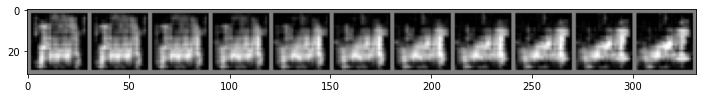

In [ ]:
output_images = []
for k in np.arange(0, 1.01, 0.1):
  print('k =', k)
  output = visualize_one_model(autoencoder, 0, 1, k)
  output_images.append(output)

result = torch.cat(output_images, dim=0)
imshow(torchvision.utils.make_grid(result, nrow=16))